<a href="https://colab.research.google.com/github/abhishekpythoninmakes/A7BC2/blob/master/cnn_model_implementing_ocr_freshone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR using CNN

In [18]:
import kagglehub

# Define the target folder
target_folder = "/content/sample_data"

# Download dataset into the specified folder
path = kagglehub.dataset_download("harieh/ocr-dataset")  # Remove the path argument

print("Path to dataset files:", path)

# Import the shutil module
import shutil

# Move the downloaded dataset to the target folder
shutil.move(path, target_folder)

print("Dataset moved to:", target_folder)

Path to dataset files: /root/.cache/kagglehub/datasets/harieh/ocr-dataset/versions/1
Dataset moved to: /content/sample_data


## Importing required libraries

In [19]:
import tensorflow as tf
print("Tensorflow imported")
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

Tensorflow imported


Setting GPU memory growth limit to prevent Out of memory issues

In [20]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
gpus

[]

## Load Dataset
Load dataset from dataset folder in grayscale format with image size 60x40 px

In [21]:
data = tf.keras.utils.image_dataset_from_directory('/content/sample_data/1/dataset',image_size=(60,40),color_mode="grayscale")

Found 210227 files belonging to 62 classes.


Image data iterator used to access images stored in batches

In [22]:
data_iter = data.as_numpy_iterator()
data_iter

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7e2683c45a10>)

Accessing next batch of images

In [23]:
batch = data_iter.next()

General lookup of how each batch variable looks and its shape <br>
Also the class names are printed

In [24]:
print(len(batch),batch[1],batch[0].shape)
print(data.class_names)
class_names = data.class_names

2 [ 2 47 41 50 30 20 35 28 31 10  1 38 37  9 35 55 17  9  3  8 61 48 24 57
 13 27 33 54 10 59 57 34] (32, 60, 40, 1)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A_U', 'B_U', 'C_U', 'D_U', 'E_U', 'F_U', 'G_U', 'H_U', 'I_U', 'J_U', 'K_U', 'L_U', 'M_U', 'N_U', 'O_U', 'P_U', 'Q_U', 'R_U', 'S_U', 'T_U', 'U_U', 'V_U', 'W_U', 'X_U', 'Y_U', 'Z_U', 'a_L', 'b_L', 'c_L', 'd_L', 'e_L', 'f_L', 'g_L', 'h_L', 'i_L', 'j_L', 'k_L', 'l_L', 'm_L', 'n_L', 'o_L', 'p_L', 'q_L', 'r_L', 's_L', 't_L', 'u_L', 'v_L', 'w_L', 'x_L', 'y_L', 'z_L']


### Plotting data to check if the loading was right

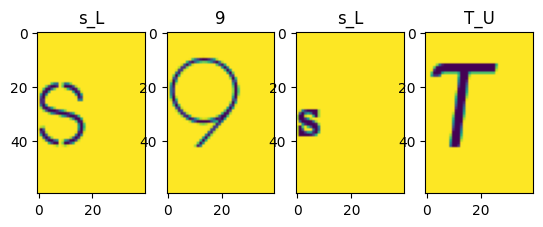

In [25]:
fig, ax = plt.subplots(1,4)
'''
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(class_names[batch[1][idx]])
'''

# Alternate way to view plots from tensorflow docs
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy().astype(int))
        ax[i].set_title(class_names[labels[i]])
#print(img.shape)
#plt.imshow(img)

## Scale data
Scaling the image data from 0 to 1 so that tensorflow can run models in it properly

In [26]:
data = data.map(lambda x,y:(x/255,y))

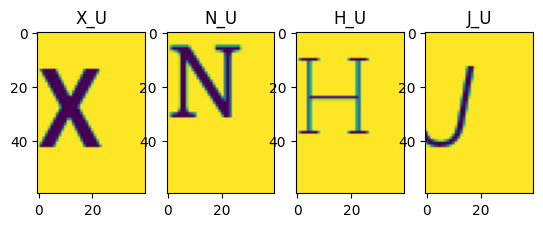

In [27]:
fig, ax = plt.subplots(1,4)
for images, labels in data.take(1):
    for i in range(4):
        ax[i].imshow(images[i].numpy())
        ax[i].set_title(class_names[labels[i]])
plt.show()

In [28]:
data_iter_val = data.as_numpy_iterator()

In [29]:
batch = data_iter_val.next()
print(batch[1])
batch[0].shape

[29 38 48  0 56 13 50 48  5 33 18 19  8 55 44 21 13  8 61 53 41  2 37 40
 36 55 44 59 33 26 28 45]


(32, 60, 40, 1)

## Splitting data
Train dataset size = 70% <br>
Testing dataset size = 20% <br>
Validation dataset size = 10%

In [30]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
print(f"Training dataset size: {train_size}\nVal. dataset size: {val_size}\nTest dataset size: {test_size}\nTotal: {len(data)}")
print(f"Total size after splitting: {train_size+test_size+val_size}")
print(f"Was the split right: {train_size+test_size+val_size==len(data)}")

Training dataset size: 4599
Val. dataset size: 1314
Test dataset size: 657
Total: 6570
Total size after splitting: 6570
Was the split right: True


In [31]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Training the Model!

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [33]:
model = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(60,40,1),padding="same"), # padding is applied
    # Each filter is of dimension 3,3,1
  AveragePooling2D(pool_size=(2,2)), # The maximum value of 2x2 sub-matrix is taken

  Conv2D(32, 3, activation='relu'),
  AveragePooling2D(pool_size=2, padding="valid"),

  Conv2D(32, 3, activation='relu'),
  AveragePooling2D(pool_size=2, padding="valid"),

  Flatten(),
  Dense(62, activation='softmax') # changed to have 62 neurons (same as number of classes) and 'softmax' activation
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 60, 40, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 30, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 18, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 14, 9, 32)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 7, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 6, 3, 32)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 62)                  │          35,774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,590 (213.24 KB)

 Trainable params: 54,590 (213.24 KB)

 Non-trainable params: 0 (0.00 B)

![model_blk_diag.svg](attachment:model_blk_diag.svg)

In [35]:
# Define a Callback class that stops training once accuracy reaches 90%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [36]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse categorical entropy in case of softmax acti. func.
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
#Fit the model
history = model.fit(train,
                    epochs=10,
                    steps_per_epoch=len(train),
                    validation_data=val,
                    callbacks=[ModelCheckpoint("./models/checkpoints_new/{epoch:02d}.h5",save_best_only=True),
                               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Epoch 1/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6319 - loss: 1.5807

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 405s 87ms/step - accuracy: 0.6320 - loss: 1.5806 - val_accuracy: 0.8408 - val_loss: 0.6424
Epoch 2/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8536 - loss: 0.5836

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 420s 83ms/step - accuracy: 0.8536 - loss: 0.5836 - val_accuracy: 0.8659 - val_loss: 0.5220
Epoch 3/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8789 - loss: 0.4685

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 367s 80ms/step - accuracy: 0.8789 - loss: 0.4685 - val_accuracy: 0.8792 - val_loss: 0.4681
Epoch 4/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8911 - loss: 0.4091

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 419s 88ms/step - accuracy: 0.8911 - loss: 0.4091 - val_accuracy: 0.8893 - val_loss: 0.4204
Epoch 5/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8981 - loss: 0.3757

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 417s 82ms/step - accuracy: 0.8981 - loss: 0.3757 - val_accuracy: 0.8874 - val_loss: 0.4129
Epoch 6/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9039 - loss: 0.3498

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 374s 81ms/step - accuracy: 0.9039 - loss: 0.3498 - val_accuracy: 0.8917 - val_loss: 0.4023
Epoch 7/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9090 - loss: 0.3303

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 382s 81ms/step - accuracy: 0.9090 - loss: 0.3303 - val_accuracy: 0.8952 - val_loss: 0.3939
Epoch 8/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9127 - loss: 0.3139

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 386s 82ms/step - accuracy: 0.9127 - loss: 0.3139 - val_accuracy: 0.8956 - val_loss: 0.3933
Epoch 9/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9160 - loss: 0.3012

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 376s 81ms/step - accuracy: 0.9160 - loss: 0.3012 - val_accuracy: 0.8996 - val_loss: 0.3812
Epoch 10/10
4599/4599 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9185 - loss: 0.2892

4599/4599 ━━━━━━━━━━━━━━━━━━━━ 370s 80ms/step - accuracy: 0.9185 - loss: 0.2892 - val_accuracy: 0.8997 - val_loss: 0.3744


In [38]:
model.save('my_ocr_model.h5')

#model_baseline.save("second_try.h5")

### Loss and Accuracy

In [40]:
# !pip install SciencePlots
import matplotlib.pyplot as plt
import scienceplots  # Import scienceplots to register the styles

epochs = [*range(1,11)]
plt.style.use(["science","no-latex","grid"])

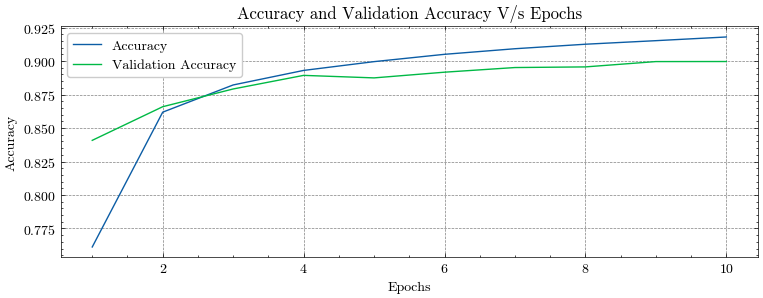

In [42]:
os.makedirs("./models/model_perf/", exist_ok=True)
fig, ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(epochs,history.history["accuracy"])
ax.plot(epochs,history.history["val_accuracy"])
ax.legend(["Accuracy","Validation Accuracy"])
ax.set_title("Accuracy and Validation Accuracy V/s Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
plt.savefig("./models/model_perf/acc_plt.png",dpi=400)
plt.show(); plt.close()

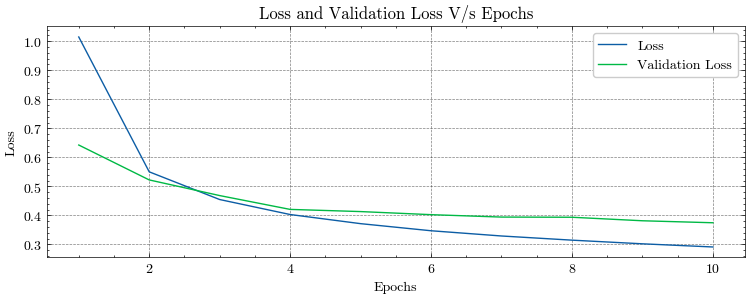

In [43]:
fig, ax = plt.subplots(1,1,figsize=(9,3))
ax.plot(epochs,history.history["loss"])
ax.plot(epochs,history.history["val_loss"])
ax.legend(["Loss","Validation Loss"])
ax.set_title("Loss and Validation Loss V/s Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.savefig("./models/model_perf/loss_plt.png",dpi=400)
plt.show(); plt.close()

### Evaluate

In [44]:
from tensorflow.keras.models import load_model

In [45]:
loaded_model = load_model("models/checkpoints_new/09.h5")

In [46]:
eval_data = loaded_model.evaluate(test)

657/657 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.8990 - loss: 0.3666


In [47]:
print(eval_data)

[0.3790142238140106, 0.9005283117294312]


In [48]:
# data_iter_val = test.as_numpy_iterator()
# test_batch = data_iter_val.next()
# print(test_batch)
predictions = np.array([])
labels = np.array([])

for x,y in test:
    predictions = np.concatenate([predictions,np.argmax(loaded_model.predict(x),axis=-1)])
    labels = np.concatenate([labels,y.numpy()])

#     print(y.numpy())
#     labels =  np.concatenate([labels,np.argmax(y.numpy(),axis=-1)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/

In [49]:
print(predictions,labels)

[ 4.  6. 13. ... 46. 29. 60.] [ 4. 40. 13. ... 46. 29. 60.]


In [50]:
import seaborn as sns

In [51]:
conf_mat = tf.math.confusion_matrix(labels,predictions)

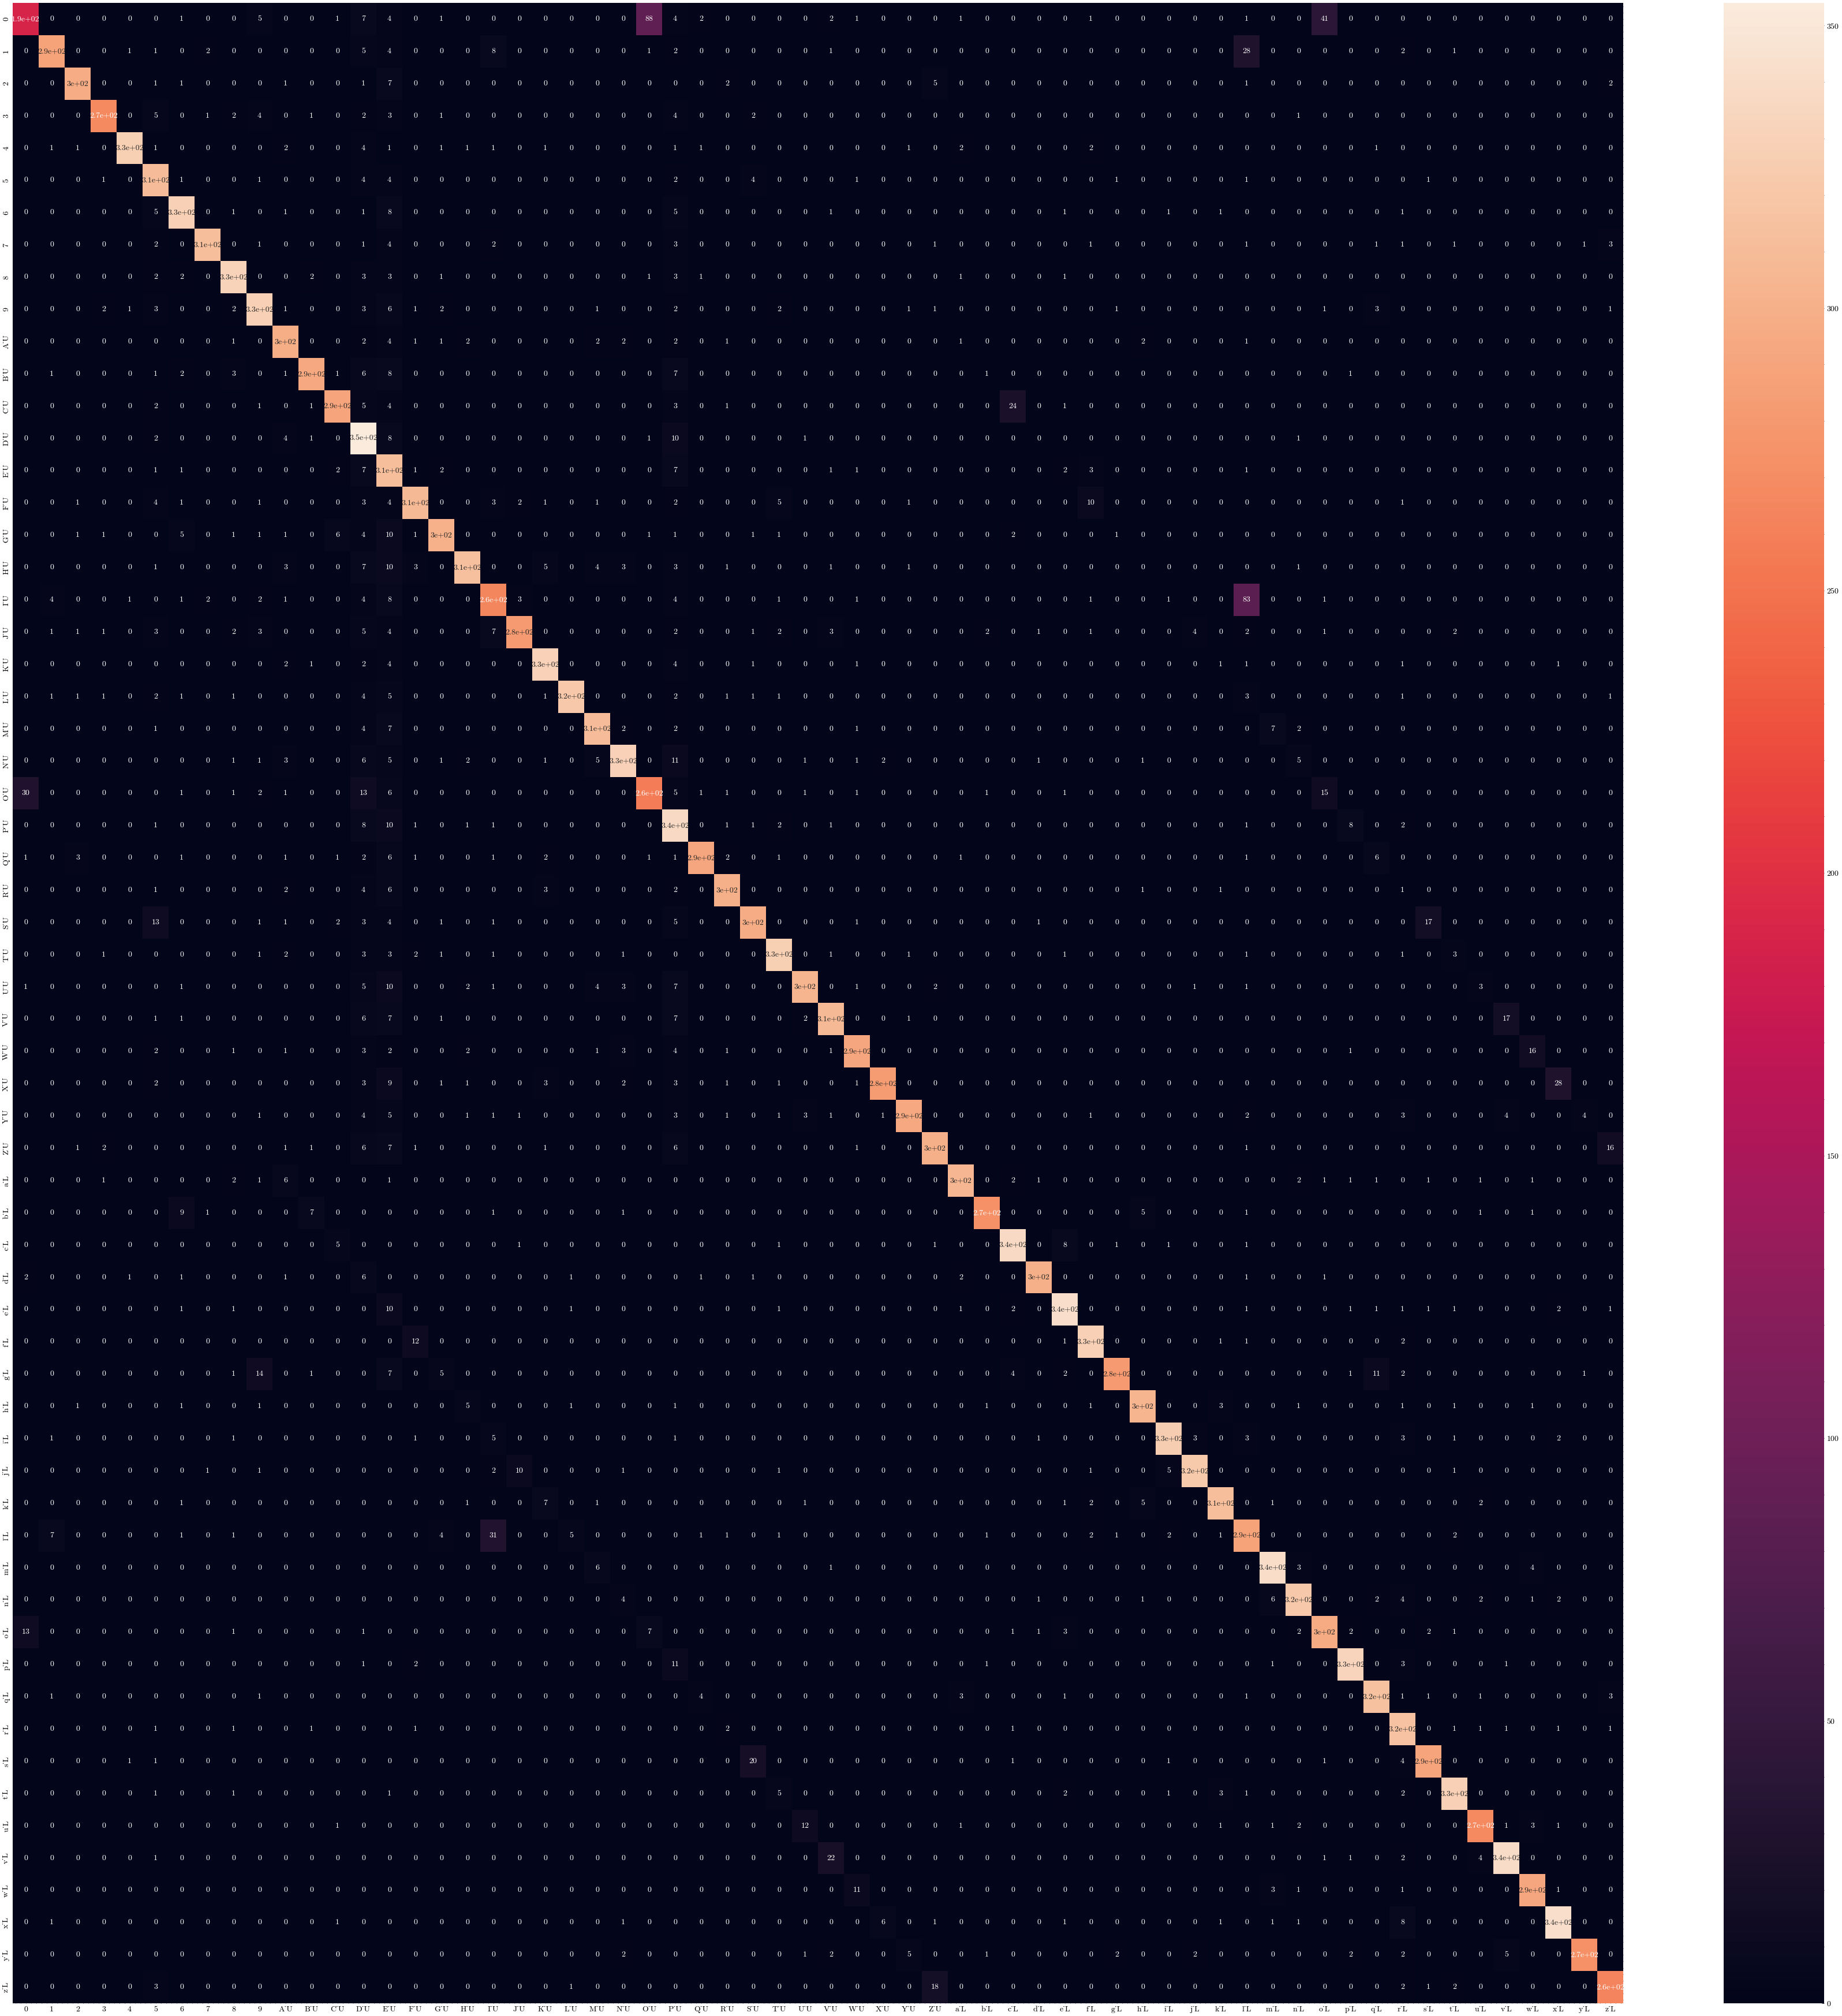

In [52]:
fig, ax = plt.subplots(figsize=(45,45))
sns.heatmap(conf_mat,ax=ax,annot=True)
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.savefig("./models/conf_matrix_new.png",dpi=400)

### Random Test

In [53]:
import random

In [99]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def load_random_images(dataset_root="./sample_data/1/dataset", num_samples=62):
    class_folders = [d for d in os.listdir(dataset_root)
                    if os.path.isdir(os.path.join(dataset_root, d))]

    random.shuffle(class_folders)
    selected_folders = class_folders[:num_samples]

    images = []
    for folder in selected_folders:
        folder_path = os.path.join(dataset_root, folder)
        image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

        if not image_files:
            continue

        for _ in range(10):
            img_name = random.choice(image_files)
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                break

    return images

# Load images with validation
max_attempts = 100
for attempt in range(max_attempts):
    images = load_random_images(num_samples=62)
    valid_images = [img for img in images if img is not None and img.ndim == 3]

    if len(valid_images) >= 62:
        valid_images = valid_images[:62]
        break

    print(f"Attempt {attempt+1}: Loaded {len(valid_images)}/62 valid images")
else:
    raise RuntimeError("Failed to load enough valid images")

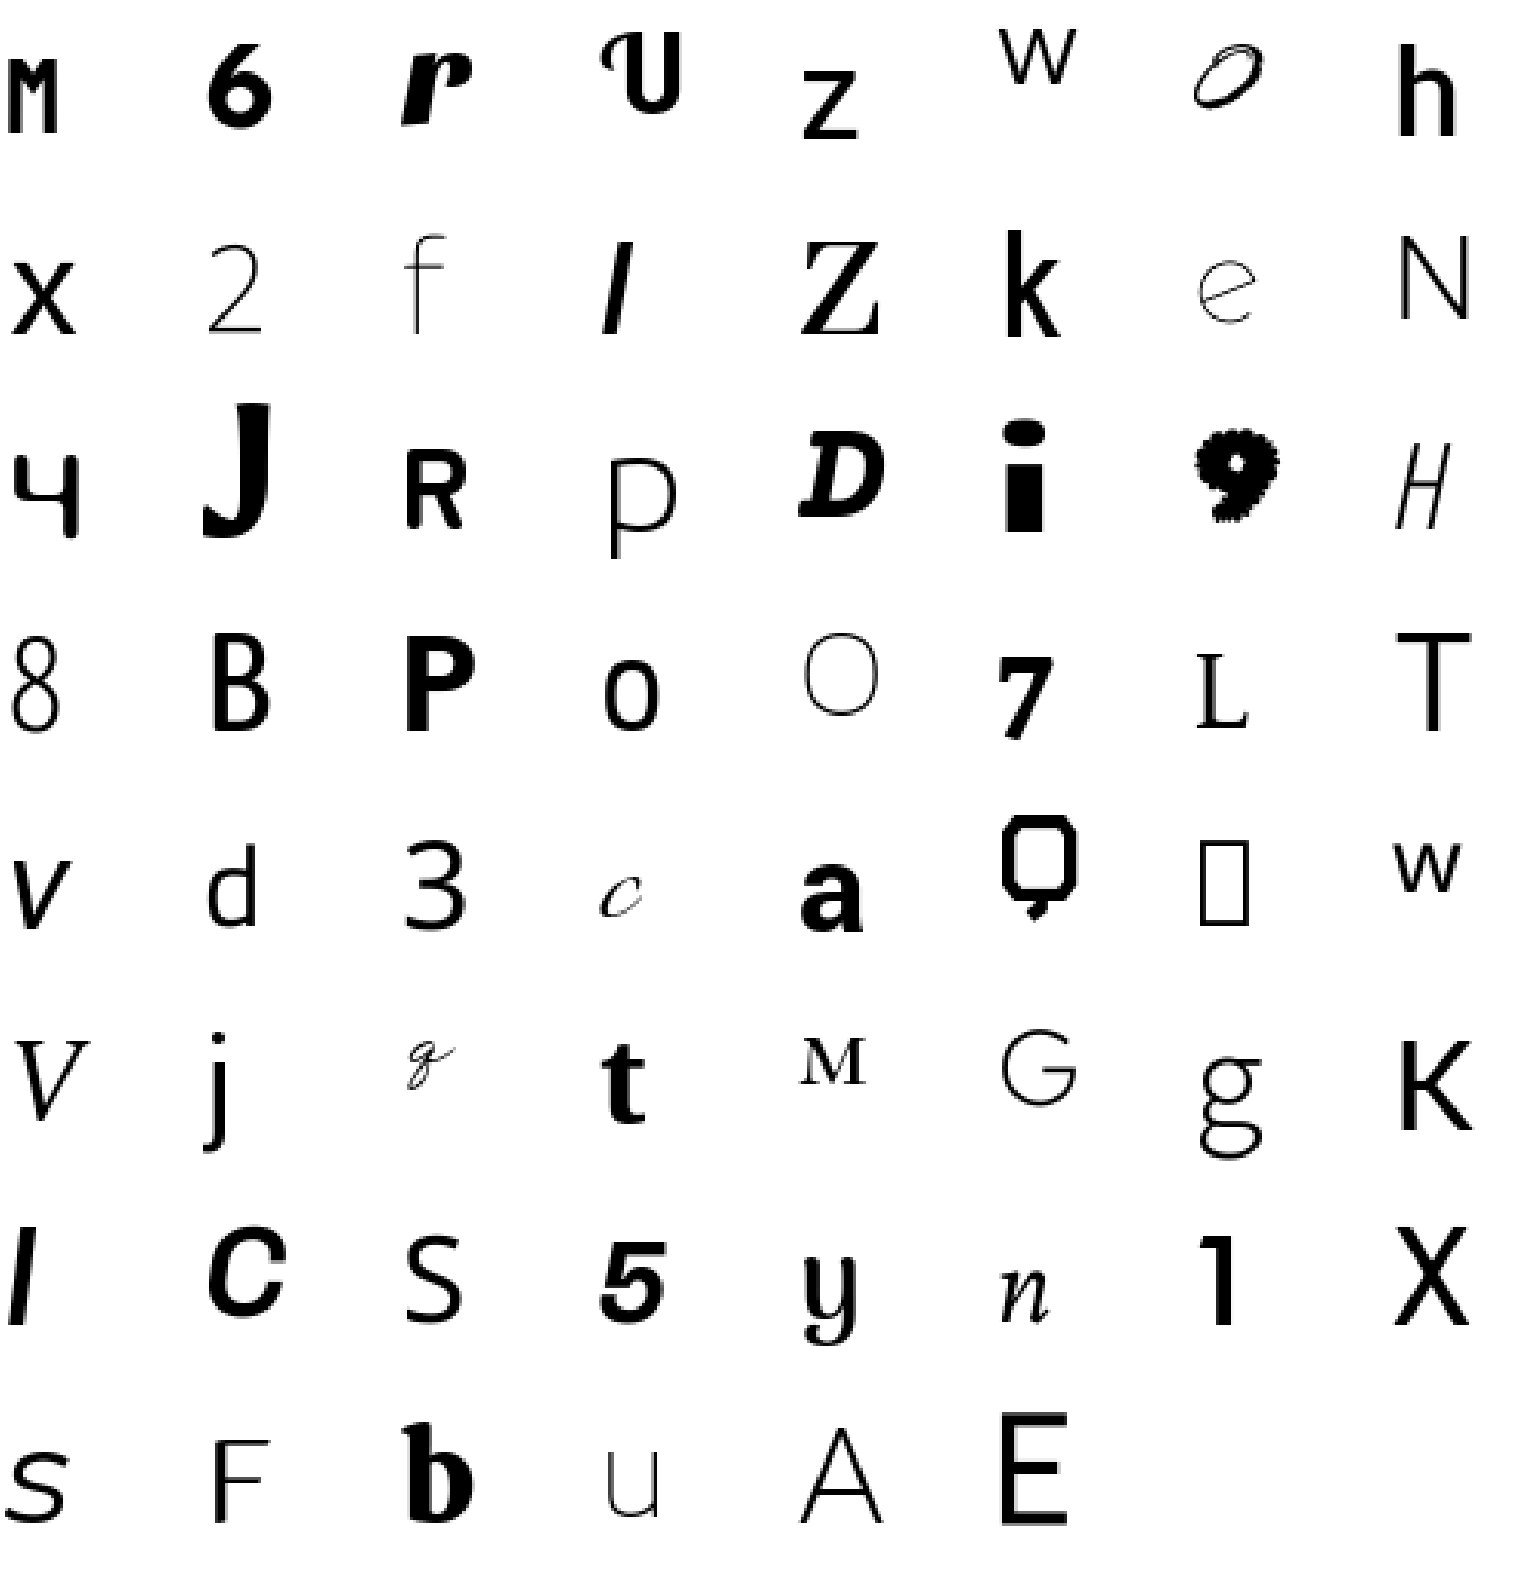

In [100]:
# Convert to tensor with proper dimensions
image_tensors = []
for img in valid_images:
    # Ensure 3-channel RGB
    if img.shape[-1] != 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    image_tensors.append(img)

# Stack to create batch dimension
image_tensor = tf.convert_to_tensor(image_tensors, dtype=tf.float32)
image_tensor = tf.image.rgb_to_grayscale(image_tensor)
resized = tf.image.resize(image_tensor, (60, 40))

# Convert back to numpy for plotting
resized_np = resized.numpy().squeeze(axis=-1)

def plot_those_imgs(images, **kwargs):
    num_images = len(images)
    cols = 8
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(16, rows*2))
    for i in range(num_images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

        if 'class_names' in kwargs:
            plt.title(kwargs['class_names'][i])

    plt.tight_layout()
    plt.show()

# Plot resized grayscale images
plot_those_imgs(resized_np)

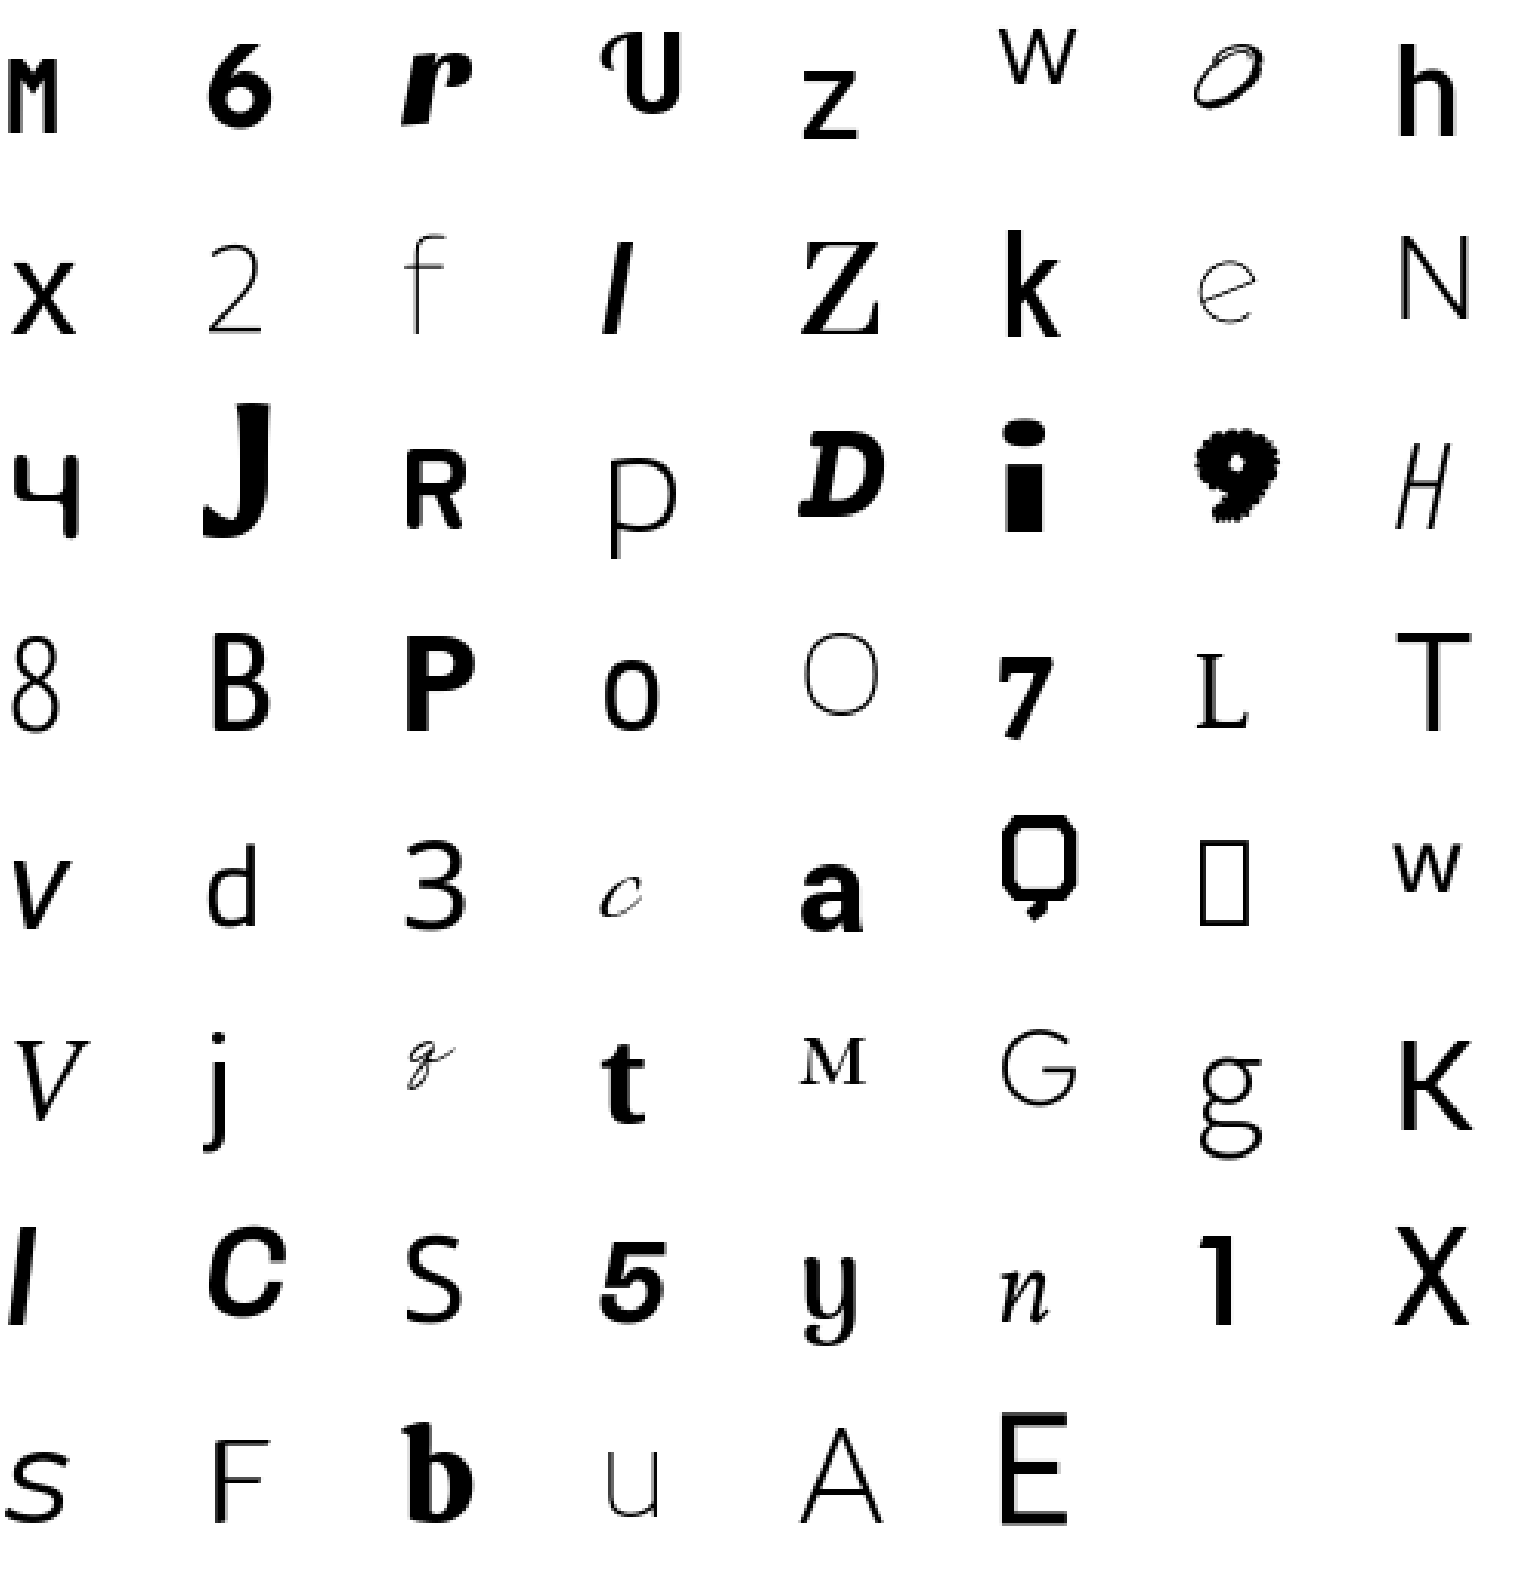

In [101]:
resize = tf.image.resize(tf.image.rgb_to_grayscale(images),(60,40))
plot_those_imgs(resize)

In [102]:
yhat = loaded_model.predict(*np.expand_dims(resize/255, 0))
yhat

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


array([[2.81112955e-09, 7.07536196e-10, 1.02841798e-11, ...,
        2.37913036e-06, 1.01867674e-10, 2.23686954e-11],
       [4.52462512e-09, 4.53016901e-20, 1.72051331e-14, ...,
        2.31078952e-16, 1.26270312e-21, 7.25712503e-15],
       [4.66023380e-07, 2.12024023e-10, 2.50590144e-08, ...,
        1.38789903e-06, 3.05840908e-10, 1.59512653e-10],
       ...,
       [1.86906379e-06, 6.27108193e-06, 9.68176295e-09, ...,
        5.16375636e-08, 1.60991058e-05, 1.40580468e-07],
       [3.12889868e-17, 5.99289173e-13, 1.45979284e-10, ...,
        9.57059258e-12, 9.32734029e-19, 1.45286549e-17],
       [7.41486200e-19, 9.54891720e-26, 1.61613198e-15, ...,
        2.00083046e-17, 1.34764785e-30, 4.01399901e-14]], dtype=float32)

['0.48 - n_L', '1.0 - 6', '0.99 - r_L', '0.87 - U_U', '0.99 - z_L', '0.99 - W_U', '0.65 - 0', '1.0 - h_L', '1.0 - x_L', '1.0 - 2', '1.0 - f_L', '0.51 - l_L', '1.0 - Z_U', '1.0 - k_L', '0.98 - e_L', '1.0 - N_U', '0.38 - u_L', '1.0 - J_U', '1.0 - R_U', '1.0 - p_L', '1.0 - D_U', '1.0 - i_L', '1.0 - 9', '1.0 - H_U', '1.0 - 8', '1.0 - B_U', '1.0 - P_U', '0.89 - o_L', '0.94 - O_U', '1.0 - 7', '1.0 - L_U', '0.99 - T_U', '1.0 - v_L', '0.99 - d_L', '1.0 - 3', '0.41 - c_L', '1.0 - a_L', '0.92 - Q_U', '0.13 - E_U', '1.0 - w_L', '1.0 - V_U', '1.0 - j_L', '0.45 - r_L', '1.0 - t_L', '1.0 - m_L', '0.82 - G_U', '1.0 - g_L', '0.99 - K_U', '0.85 - l_L', '1.0 - C_U', '0.99 - S_U', '1.0 - 5', '1.0 - y_L', '0.73 - n_L', '0.99 - 1', '1.0 - X_U', '1.0 - s_L', '0.98 - F_U', '1.0 - b_L', '0.97 - u_L', '1.0 - A_U', '1.0 - E_U']


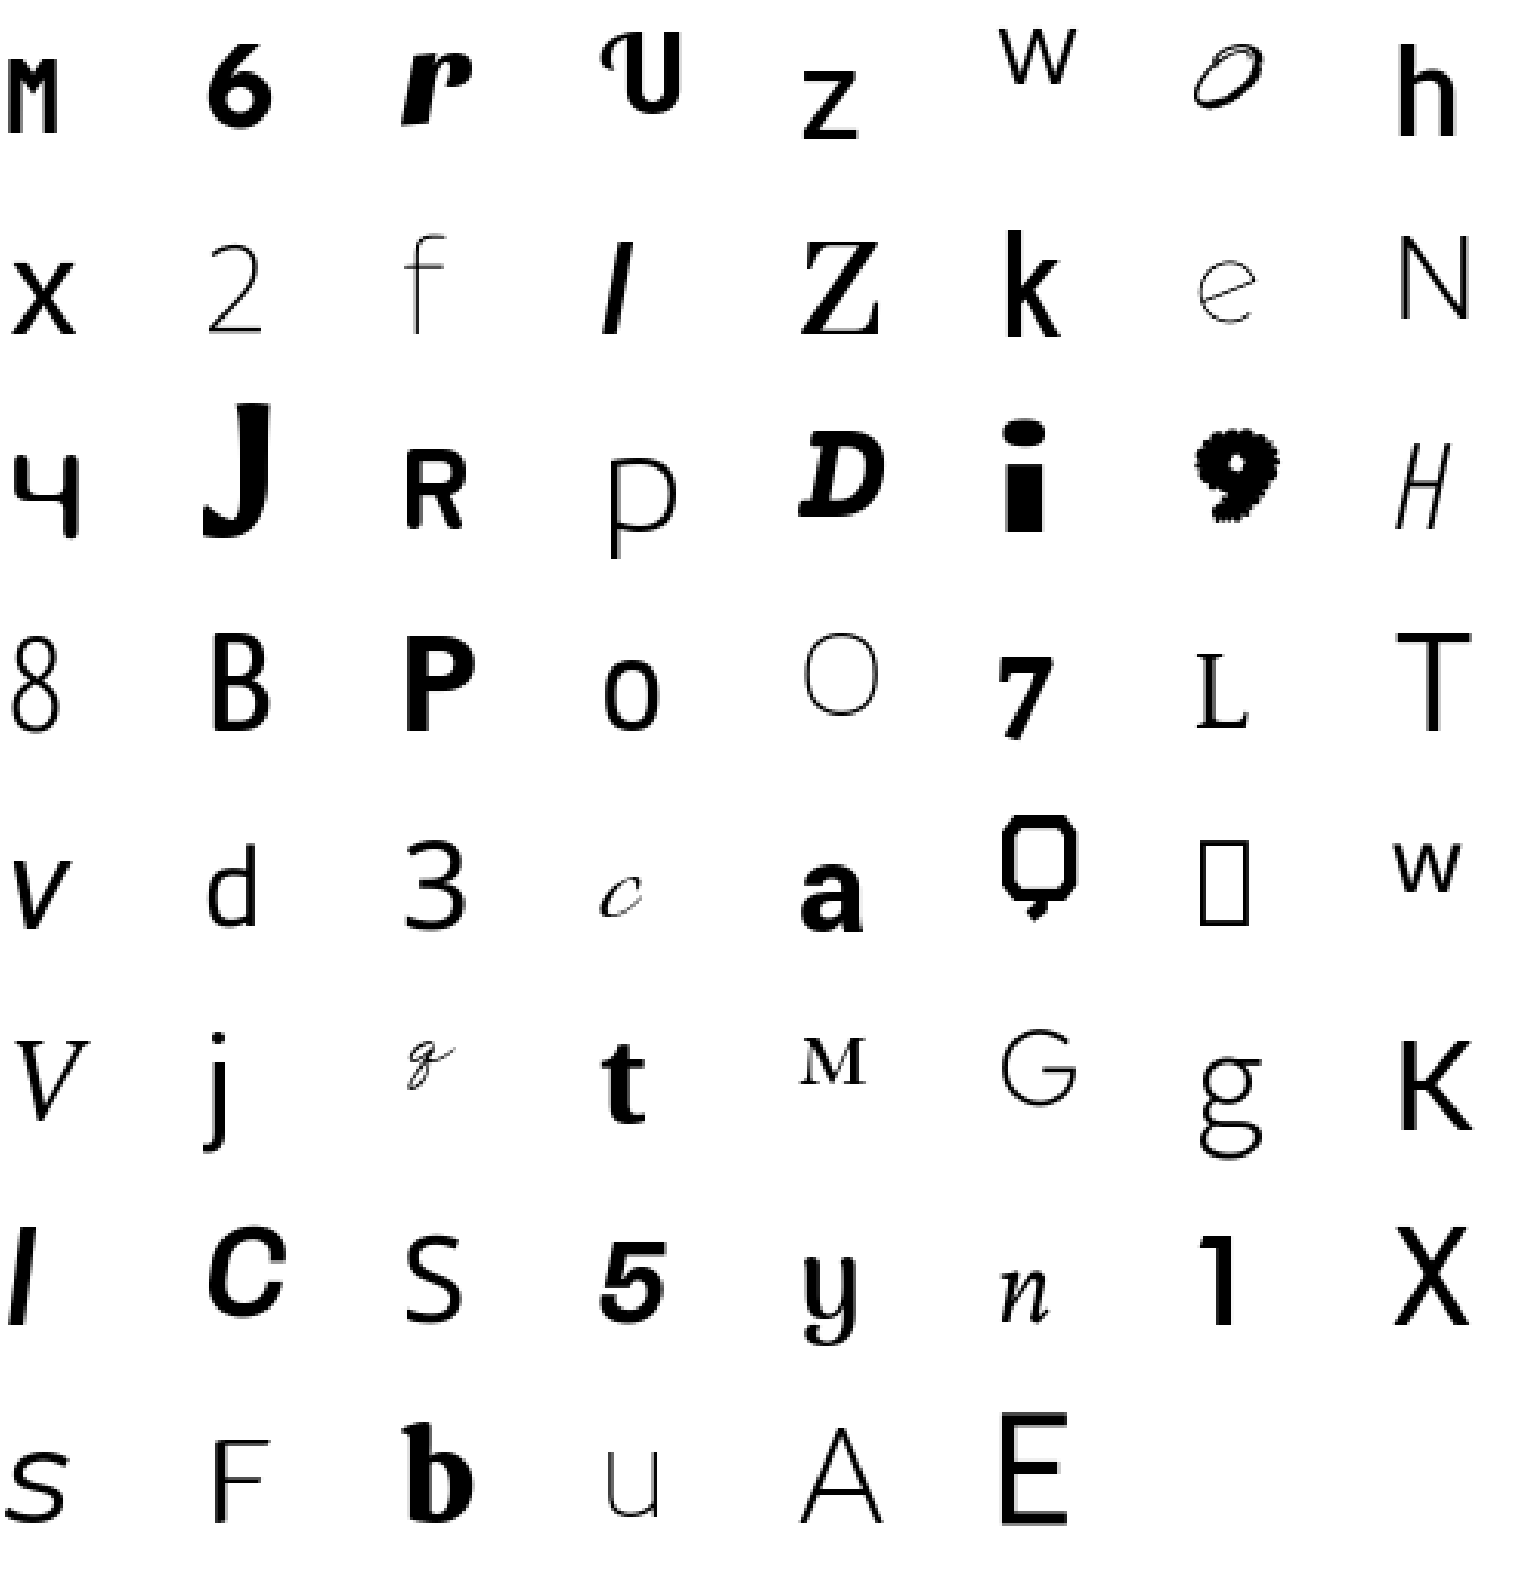

In [103]:
acc_pred = [f"{round(float(yhat[i][np.argmax(yhat[i])]),2)} - {class_names[np.argmax(yhat[i])]}" for i in range(len(yhat))]
print(acc_pred)
plot_those_imgs(resize,acc=acc_pred)

In [110]:
# Create a proper 62-class mapping (digits + uppercase + lowercase)
char_map = {
    idx: char for idx, char in enumerate(
        ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] +  # 0-9 (10)
        [chr(i) for i in range(ord('A'), ord('Z')+1)] +        # A-Z (26)
        [chr(i) for i in range(ord('a'), ord('z')+1)]          # a-z (26)
    )
}

In [119]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load trained model
loaded_model = load_model('my_ocr_model.h5')

# Preprocessing function
def preprocess_image(image_path, target_size=(60, 40)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (60,40,1)
    img = np.expand_dims(img, axis=0)   # Add batch dimension (1,60,40,1)
    return img

# Prediction function
def predict_text(image_path):
    # Preprocess input
    input_img = preprocess_image(image_path)

    # Get predictions
    predictions = loaded_model.predict(input_img, verbose=0)

    # Convert prediction to character
    predicted_class = np.argmax(predictions, axis=-1)[0]
    confidence = np.max(predictions) * 100

    return {
        'character': char_map.get(predicted_class, '?'),
        'confidence': round(confidence, 2),
        'class_index': predicted_class
    }

# Example usage
if __name__ == "__main__":
    image_path = '/content/sample_data/1/dataset/3/1000.png'
    result = predict_text(image_path)
    print(f"Predicted: {result['character']} "
          f"(Class {result['class_index']}, "
          f"Confidence: {result['confidence']}%)")

Predicted: 3 (Class 3, Confidence: 82.06999969482422%)


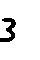

Extracted text: 3


In [144]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

# Load trained model
loaded_model = load_model('my_ocr_model.h5')

# 62-class mapping (digits + uppercase + lowercase)
char_map = {
    idx: char for idx, char in enumerate(
        ['0','1','2','3','4','5','6','7','8','9'] +
        [chr(i) for i in range(ord('A'), ord('Z')+1)] +
        [chr(i) for i in range(ord('a'), ord('z')+1)]
    )
}

def preprocess_image(img, target_size=(60, 40)):
    """Consistent preprocessing for all pipelines"""
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

def extract_text_sequence(image_path, debug=False):
    # Read image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original = image.copy()
    h_original, w_original = original.shape

    # Improved thresholding for text segmentation
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)  # Remove noise

    # Find all contours (not just external)
    contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if debug:
        cv2_imshow(binary)

    text_sequence = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Validate contour size and aspect ratio
        if w < 10 or h < 10 or w/h > 3 or h/w > 3:
            continue

        # Clamp coordinates with padding
        x1 = max(0, x-5)
        y1 = max(0, y-5)
        x2 = min(w_original, x + w + 5)
        y2 = min(h_original, y + h + 5)

        # Skip invalid ROIs
        if x2 <= x1 or y2 <= y1:
            continue

        # Crop from ORIGINAL IMAGE (non-binary)
        roi = original[y1:y2, x1:x2]
        roi = cv2.resize(roi, (60, 40))

        # Preprocess and predict
        processed = preprocess_image(roi)
        predictions = loaded_model.predict(processed, verbose=0)
        predicted_class = np.argmax(predictions, axis=-1)[0]
        confidence = np.max(predictions) * 100

        # Filter and add to sequence
        if confidence > 60:
            text_sequence.append(char_map.get(predicted_class, '?'))

    # Post-processing: Remove duplicates and handle spaces
    cleaned_text = ''.join(text_sequence).replace('?', '')
    cleaned_text = ' '.join(cleaned_text.split())  # Handle multiple spaces

    return cleaned_text

# Example usage
image_path = '/content/sample_data/1/dataset/3/1000.png'
extracted_text = extract_text_sequence(image_path, debug=True)
print(f"Extracted text: {extracted_text}")